# Regrid from WOA18 to eANT025 for initial conditions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cf
import gsw
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.file_io import read_woa

### Initial condition code

World Ocean Atlas seems waaaay colder at the surface than B-SOSE; that doesn't quite seem right.

In [82]:
ds1 = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/initial-conditions/WOA23-AbsSal-initial-conditions-20241023.nc')

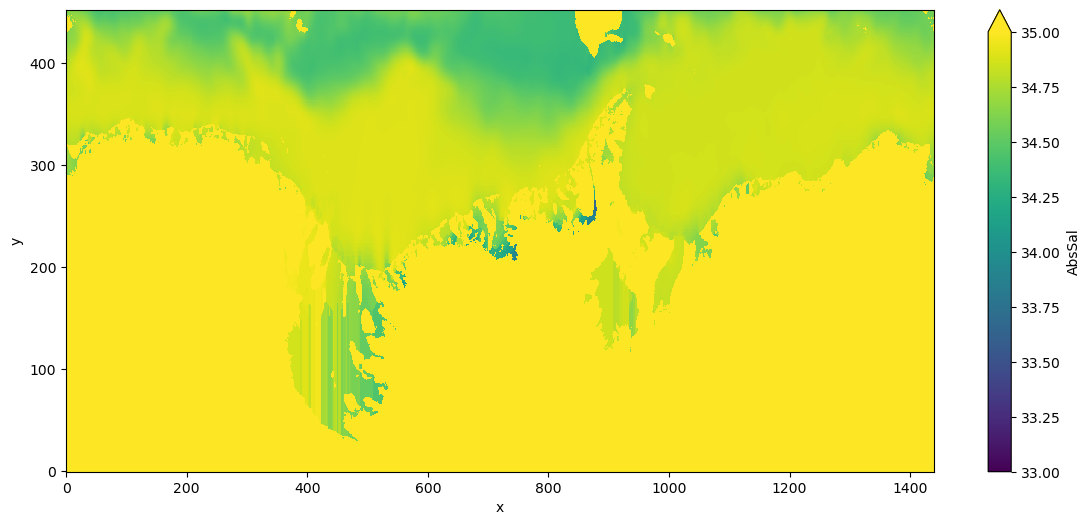

In [50]:
ds1.isel(time_counter=0, deptht=50).AbsSal.plot(figsize=(14,6), vmin=33, vmax=35)

In [22]:
# Load gridT files into dataset:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/' 
nemo_ds  = xr.open_dataset(f'{base_dir}output/CESM2-present-day5/files/eANT025.L121_1m_19790101_19791231_grid_T.nc').isel(time_counter=0)
nemo_ds = nemo_ds.rename({'e3t':'thkcello', 'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area', 'e3t':'thkcello',
                          'nav_lon_grid_T':'nav_lon', 'nav_lat_grid_T':'nav_lat', 'bounds_nav_lon_grid_T':'bounds_lon', 
                          'bounds_nav_lat_grid_T':'bounds_lat',
                          'nvertex_grid_T':'nvertex'})

WOA_files  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/WOA23/woa23_decav71A0_*.nc'
woa = xr.open_mfdataset(WOA_files, decode_times=False).isel(time=0)

abs_salt = gsw.SA_from_SP(woa['s_an'], np.abs(woa.depth), woa['lon'], woa['lat'])
woa_temp = gsw.CT_from_t(abs_salt, woa['t_an'], np.abs(woa.depth))

WOA = xr.Dataset({'temp':woa_temp.isel(depth=0), 'salt':abs_salt.isel(depth=0)}).drop_vars('depth').squeeze()
WOA_interp = interp_latlon_cf(WOA, nemo_ds, method='bilinear')

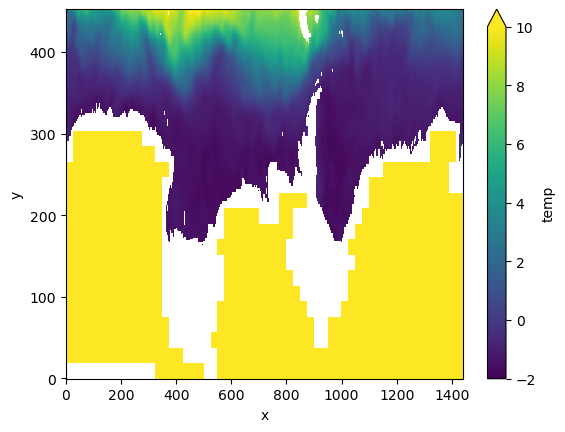

In [42]:
WOA_interp.temp.plot(vmin=-2, vmax=10)

In [43]:
SOSE_ini = xr.open_dataset(f'{base_dir}initial-conditions/SOSE-ConsTemp-initial-conditions-20240507.nc')

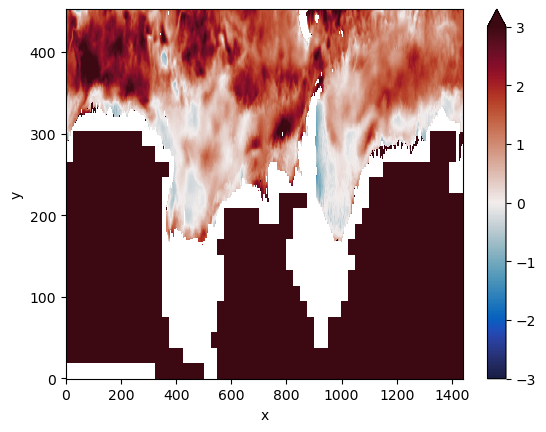

In [44]:
(SOSE_ini.isel(time_counter=0, deptht=0).ConsTemp - WOA_interp.temp).plot(vmin=-3, vmax=3, cmap=cmocean.cm.balance)

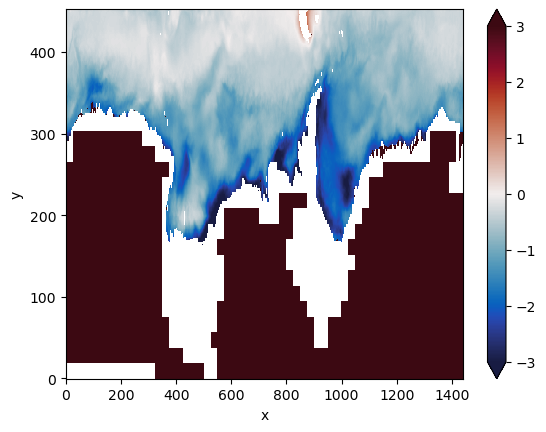

In [45]:
SOSE_ini = xr.open_dataset(f'{base_dir}initial-conditions/SOSE-AbsSal-initial-conditions-20240507.nc')
(SOSE_ini.isel(time_counter=0, deptht=0).AbsSal - WOA_interp.salt).plot(vmin=-3, vmax=3, cmap=cmocean.cm.balance)

In [ ]:
# Fill areas that are masked in source dataset but not in NEMO with nearest neighbours:
nemo_mask_ds  = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20231025.nc')
    SOSE_extended = fill_ocean(SOSE_interp, variable, nemo_mask_ds, dim=dimension, niter=num_iter, fill_val=fill_value, grid=grid_type)

    # Final processing (fill NaNs with a real value and shift very deepest grid cell value):
    if ~np.isnan(land_value):
        SOSE_extended[variable] = xr.where(np.isnan(SOSE_extended[variable]), land_value, SOSE_extended[variable])
       # SOSE_extended[variable] = xr.where(np.abs(SOSE_extended[variable]) < 1e-4, land_value, SOSE_extended[variable]) # for sea ice masking
    else:
        SOSE_extended[variable] = xr.where(np.isnan(SOSE_extended[variable]), 9999, SOSE_extended[variable])
    if dimension=='3D':
        SOSE_extended[variable] = xr.where(SOSE_extended.z == SOSE_extended.z[-1], SOSE_extended[variable].isel(z=-2), SOSE_extended[variable])
        SOSE_extended[variable] = ('time_counter','deptht','y','x'), SOSE_extended[variable].values[np.newaxis, ...]

In [ ]:
def create_ics(variable, in_file, out_file,
               source='SOSE',
               source_coord='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
               nemo_coord  ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/coordinates_AIS.nc',
               nemo_mask   ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc',
               salt_file   ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc',
               folder      ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/initial-conditions/',
               fill_value  = np.nan,
               land_value  = np.nan,
               num_iter    = 100,
               grid_type   = 'T'):

    print(f'---- Creating NEMO initial conditions for variable {variable} from {source} ----')
    if source not in ['SOSE', 'NEMO']: raise Exception('Functions only set up for SOSE or NEMO restart file currently')

    # Check number of dimensions of variable (2D or 3D):
    dimension = f"{len(xr.open_dataset(f'{in_file}')[variable].dims)}D"
    if dimension != '2D' and dimension !='3D': raise Exception('Input variable must be either 2D or 3D')

    # Specify coordinate names:
    if source=='SOSE':
        if dimension=='2D':   name_remapping = {'XC':'lon', 'YC':'lat'}
        elif dimension=='3D': name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}

    # Dictionary specifying file names and locations for subsequent functions:
    interp_info = {'source': source,
                   'variable': variable,
                   'nemo_coord': nemo_coord,
                   'nemo_mask': nemo_mask,
                   'source_coord': source_coord,
                   'salt_file':salt_file,
                   'dim':dimension,
                   'renaming':name_remapping}

    # Horizontally interpolate source dataset to NEMO grid:
    ics_obcs_horizontal_interp(interp_info, in_file, f'{folder}temp/{source}-{variable}-IC-horizontal-interp.nc')

    if dimension=='3D':
       # Vertically interpolate the above horizontally interpolated dataset to NEMO grid:
       vertical_interp(interp_info, f'{folder}temp/{source}-{variable}-IC-horizontal-interp.nc', f'{folder}temp/{source}-{variable}-IC-vertical-interp.nc')
       SOSE_interp   = xr.open_dataset(f'{folder}temp/{source}-{variable}-IC-vertical-interp.nc')
    elif dimension=='2D':
       SOSE_interp   = xr.open_dataset(f'{folder}temp/{source}-{variable}-IC-horizontal-interp.nc')

    # Fill areas that are masked in source dataset but not in NEMO with nearest neighbours:
    nemo_mask_ds  = xr.open_dataset(f'{nemo_mask}')
    SOSE_extended = fill_ocean(SOSE_interp, variable, nemo_mask_ds, dim=dimension, niter=num_iter, fill_val=fill_value, grid=grid_type)

    # Final processing (fill NaNs with a real value and shift very deepest grid cell value):
    if ~np.isnan(land_value):
        SOSE_extended[variable] = xr.where(np.isnan(SOSE_extended[variable]), land_value, SOSE_extended[variable])
       # SOSE_extended[variable] = xr.where(np.abs(SOSE_extended[variable]) < 1e-4, land_value, SOSE_extended[variable]) # for sea ice masking
    else:
        SOSE_extended[variable] = xr.where(np.isnan(SOSE_extended[variable]), 9999, SOSE_extended[variable])
    if dimension=='3D':
        SOSE_extended[variable] = xr.where(SOSE_extended.z == SOSE_extended.z[-1], SOSE_extended[variable].isel(z=-2), SOSE_extended[variable])
        SOSE_extended[variable] = ('time_counter','deptht','y','x'), SOSE_extended[variable].values[np.newaxis, ...]
    elif dimension=='2D':
        SOSE_extended[variable] = ('time_counter','y','x'), SOSE_extended[variable].values[np.newaxis, ...]

    # Write output to file:
    SOSE_extended.to_netcdf(f'{out_file}', unlimited_dims='time_counter')
    return


### Boundary conditions (like what I did for B-SOSE)

In [52]:
month=1; season=13;
project='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
variable='t'

file_seasonal_WOA = f'{project}WOA23/climatology/woa23_decav71A0_{variable}{season}_04.nc'
file_monthly_WOA  = f'{project}WOA23/climatology/woa23_decav71A0_{variable}{month:02}_04.nc';
seasonal = xr.open_dataset(file_seasonal_WOA, decode_times=False)
monthly  = xr.open_dataset(file_monthly_WOA, decode_times=False)

In [94]:
sose = xr.open_dataset(f'{project}boundary-conditions/B-SOSE/SOSE-ConsTemp-boundary-conditions-20240911_m01.nc')
bc1 = xr.open_dataset(f'{project}boundary-conditions/WOA/WOA23-ConsTemp-boundary-conditions-20241024_m01.nc')

In [85]:
nemo_ds  = xr.open_dataset(f'{project}output/CESM2-present-day5/files/eANT025.L121_1m_19790101_19791231_grid_T.nc').isel(time_counter=0)

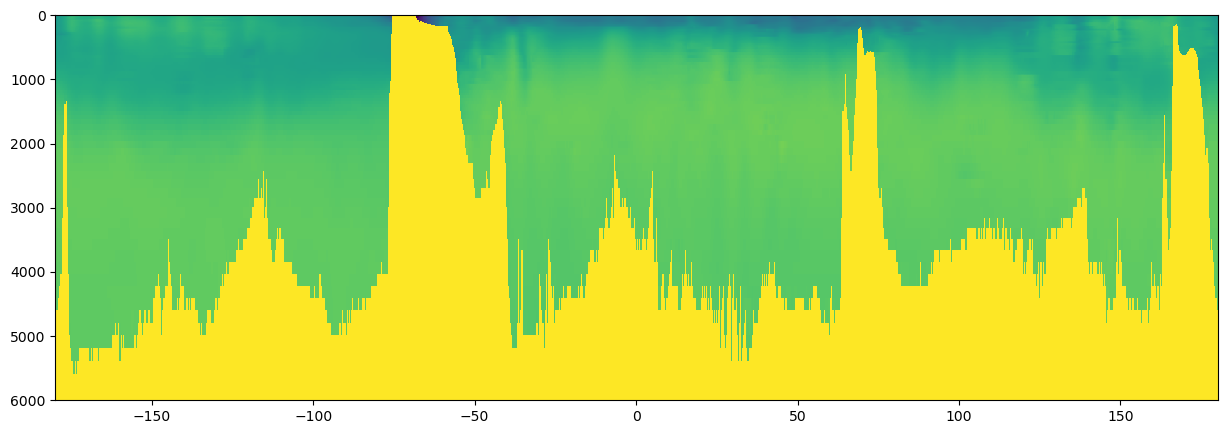

In [88]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.pcolormesh(bc1.isel(time_counter=0,y=0).sortby('x').x, nemo_ds.deptht, bc1.isel(time_counter=0,y=0)['AbsSal'].sortby('x'), vmin=33, vmax=35.5)
ax.invert_yaxis()

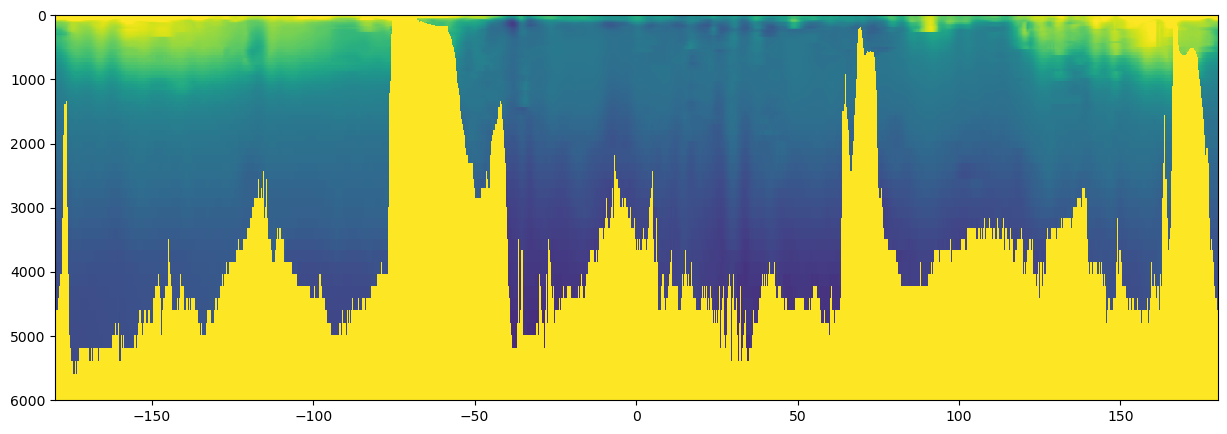

In [97]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.pcolormesh(bc1.isel(time_counter=0,y=0).sortby('x').x, nemo_ds.deptht, bc1.isel(time_counter=0,y=0)['ConsTemp'].sortby('x'), vmin=-2, vmax=9)
ax.invert_yaxis()

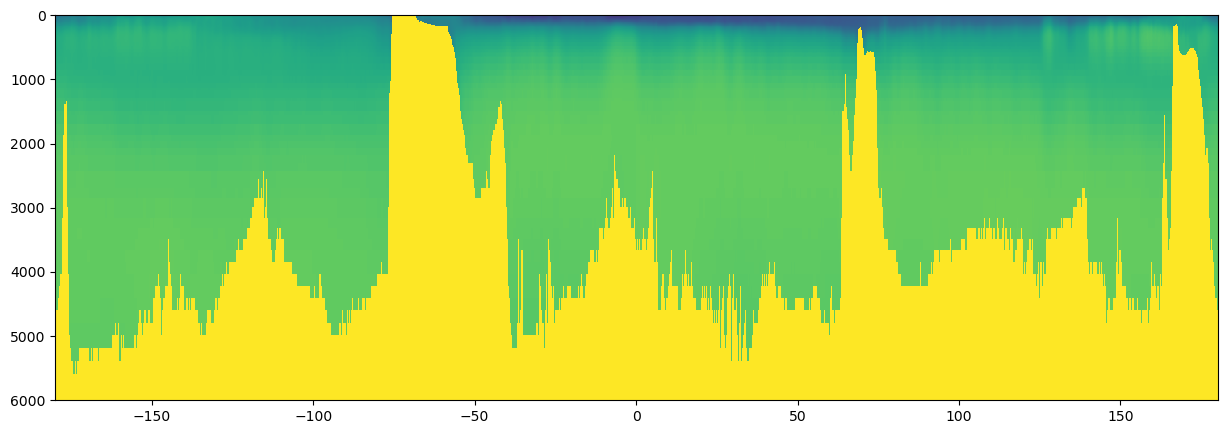

In [92]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.pcolormesh(sose.isel(time_counter=0,y=0).sortby('x').x, nemo_ds.deptht, sose.isel(time_counter=0,y=0)['AbsSal'].sortby('x'), vmin=33, vmax=35.5)
ax.invert_yaxis()

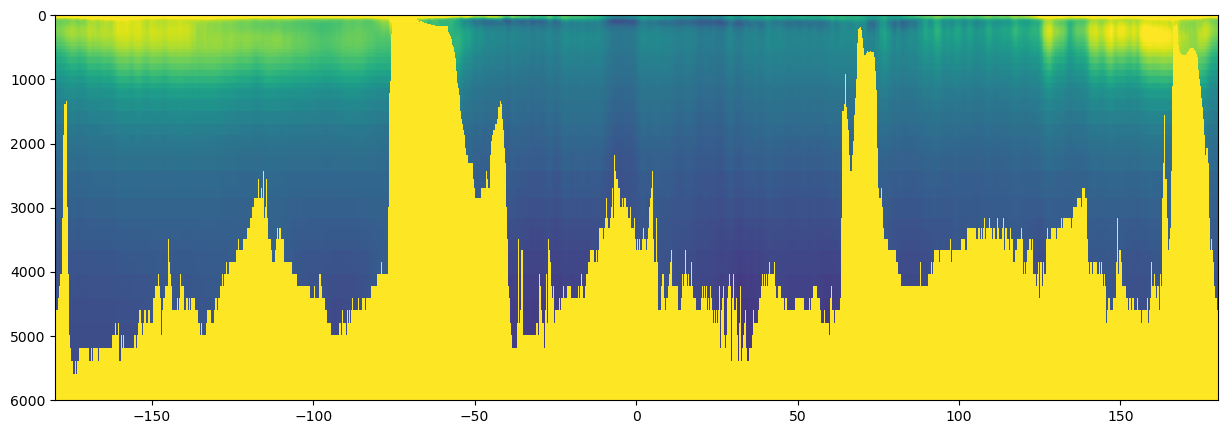

In [98]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.pcolormesh(sose.isel(time_counter=0,y=0).sortby('x').x, nemo_ds.deptht, sose.isel(time_counter=0,y=0)['ConsTemp'].sortby('x'), vmin=-2, vmax=9)
ax.invert_yaxis()

In [99]:
monthly_fulldepth = xr.open_dataset(f'{project}WOA23/climatology/woa23_decav71A0_t01_04_combined.nc', decode_times=False)

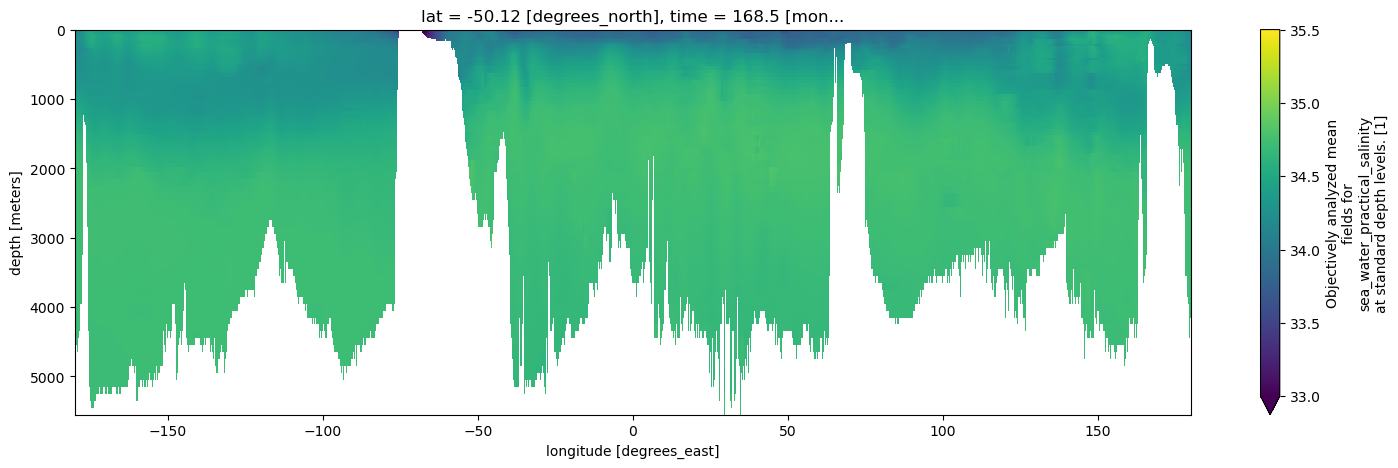

In [90]:
fig, ax = plt.subplots(1,1, figsize=(18,5))
monthly_fulldepth['s_an'].isel(time=0, lat=159).plot(ax=ax, vmin=33, vmax=35.5)
ax.invert_yaxis()

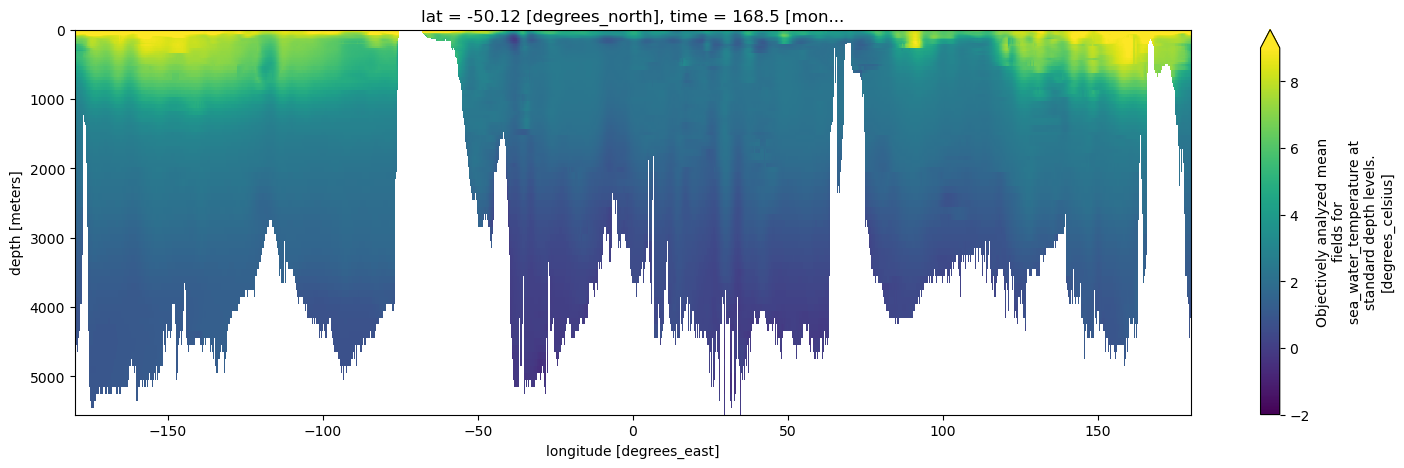

In [101]:
fig, ax = plt.subplots(1,1, figsize=(18,5))
monthly_fulldepth['t_an'].isel(time=0, lat=159).plot(ax=ax, vmin=-2, vmax=9)
ax.invert_yaxis()

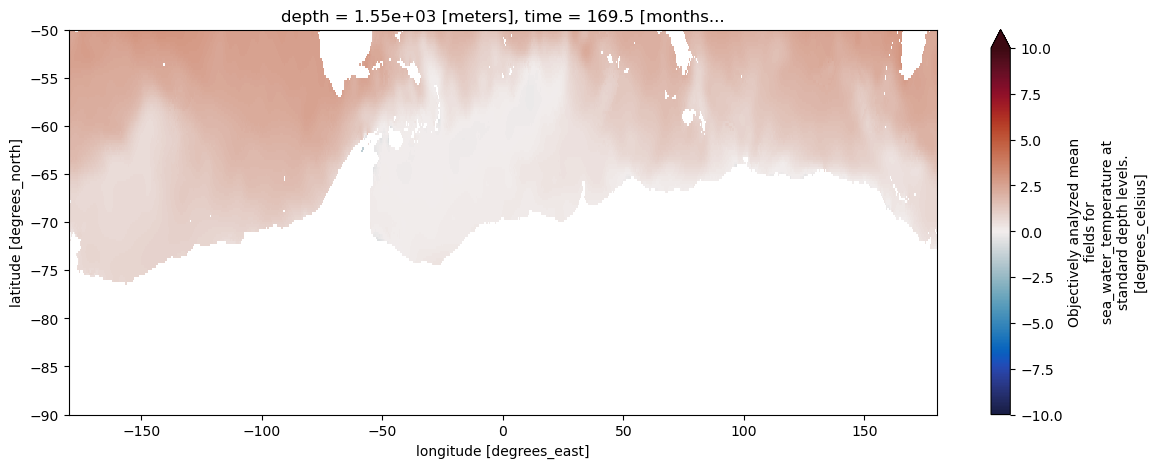

In [48]:
seasonal.isel(time=0, depth=57).plot(ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance, figsize=(14,5))

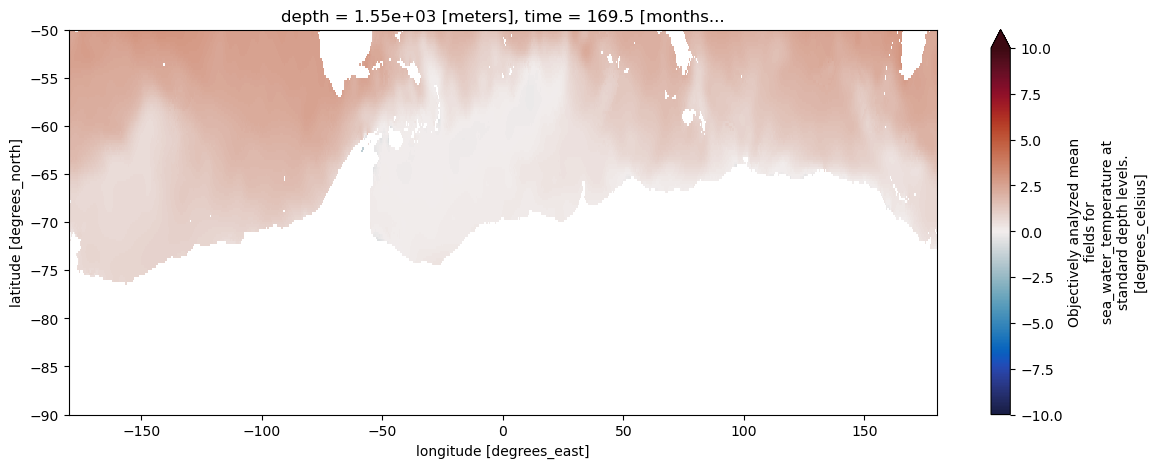

In [46]:
monthly_fulldepth.isel(time=0, depth=57).plot(ylim=(-90,-50), vmin=-10, vmax=10, cmap=cmocean.cm.balance, figsize=(14,5))

In [13]:
xr.combine_by_coords([seasonal, monthly])#, compat="override")

<xarray.Dataset> Size: 846MB
Dimensions:  (time: 2, depth: 102, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 8B 168.5 169.5
Data variables:
    t_an     (time, depth, lat, lon) float32 846MB nan nan nan ... nan nan nan